## **Deep Q-Network for Resource Scaling**
**A DQN agent is used to decide whether to scale up, scale down, or take no action.**

1. Import libraries

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from collections import defaultdict
import time
import pickle
import sys
import math
from datetime import datetime, timedelta
from sklearn.metrics import mean_absolute_error, mean_squared_error

2. Parameters and dataset paths

- Set random seeds for reproducibility. Define Q-learning hyperparameters and file paths

In [ ]:
# Set random seed for reproducibility
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Enhanced Q-learning parameters
LEARNING_RATE = 0.05
GAMMA = 0.99  # Increased discount factor for more future-oriented decisions
LAMBDA_PARAM = 0.85  # Eligibility trace decay parameter 
EPS_START = 1.0
EPS_END = 0.02  # Slightly higher to maintain some exploration
EPS_DECAY = 0.97  # Slower decay for more thorough exploration
BINS_PER_DIM = 8  # Increased for finer state discretization

# Define paths to dataset files
DATA_FILES = {
    'ec2': '../dataset scripts/reduced_ec2_data.csv',
    'rds': '../dataset scripts/reduced_rds_data.csv',
    'ecs': '../dataset scripts/reduced_ecs_data.csv'
}

3. Synthetic data creation

- Generate synthetic EC2, RDS, and ECS data with realistic patterns if data is not available

In [ ]:
# Function to create synthetic data when real data isn't available
def create_synthetic_data():
    """
    Create synthetic data for EC2, RDS, and ECS when the real CSV files are not available.
    """
    print("Creating synthetic data...")
    synthetic_data = {}
    
    # Create a date range for one week with 5-minute intervals
    start_date = datetime(2023, 1, 1)
    end_date = start_date + timedelta(days=7)
    date_range = pd.date_range(start=start_date, end=end_date, freq='5min')
    
    for service in ['ec2', 'rds', 'ecs']:
        # Create a dataframe with timestamp index
        df = pd.DataFrame(index=date_range)
        df.index.name = 'timestamp'
        
        # Add CPU utilization with realistic patterns
        # Base pattern: daily cycle with peak during work hours
        hour_of_day = df.index.hour
        day_of_week = df.index.dayofweek
        
        # Create base CPU pattern (higher during work hours, lower at night)
        base_cpu = 30 + 30 * np.sin(np.pi * (hour_of_day - 6) / 12) * (hour_of_day >= 6) * (hour_of_day <= 18)
        
        # Weekend factor (lower usage on weekends)
        weekend_factor = 0.7 if service == 'ec2' else (0.5 if service == 'rds' else 0.8)
        weekend_mask = (day_of_week >= 5)
        base_cpu[weekend_mask] = base_cpu[weekend_mask] * weekend_factor
        
        # Add some randomness
        noise = np.random.normal(0, 10, size=len(df))
        
        # Add some spikes (to simulate peak loads)
        num_spikes = 10
        spike_idx = np.random.choice(len(df), size=num_spikes, replace=False)
        spike_values = np.random.uniform(20, 50, size=num_spikes)
        spike_contributions = np.zeros(len(df))
        spike_contributions[spike_idx] = spike_values
        
        # Combine all components
        cpu_values = base_cpu + noise + spike_contributions
        
        # Ensure values are within valid range [0, 100]
        cpu_values = np.clip(cpu_values, 0, 100)
        
        # Add to dataframe
        df[f'{service.upper()}_CPUUtilization'] = cpu_values
        
        # Add time features
        df['hour'] = df.index.hour
        df['day_of_week'] = df.index.dayofweek
        
        # Add additional metrics based on service
        if service == 'ec2':
            # Memory utilization correlates with CPU but not perfectly
            df['EC2_MemoryUtilization'] = 0.7 * cpu_values + 0.3 * np.random.normal(50, 10, size=len(df))
            df['EC2_MemoryUtilization'] = np.clip(df['EC2_MemoryUtilization'], 0, 100)
            
            # Network traffic correlates loosely with CPU
            df['EC2_NetworkIn'] = 100 * (0.5 * cpu_values/100 + 0.5 * np.random.exponential(1, size=len(df)))
            df['EC2_NetworkOut'] = 0.7 * df['EC2_NetworkIn'] + 0.3 * np.random.exponential(100, size=len(df))
            
            # Disk operations
            df['EC2_DiskReadOps'] = 50 * (0.3 * cpu_values/100 + 0.7 * np.random.exponential(1, size=len(df)))
            df['EC2_DiskWriteOps'] = 1.5 * df['EC2_DiskReadOps'] + 20 * np.random.exponential(1, size=len(df))
        
        elif service == 'rds':
            # Database metrics
            df['RDS_FreeableMemory'] = 1000 * (1 - 0.7 * cpu_values/100 + 0.3 * np.random.normal(0, 0.1, size=len(df)))
            df['RDS_FreeableMemory'] = np.clip(df['RDS_FreeableMemory'], 100, 1000)
            
            # Database connections
            df['RDS_DatabaseConnections'] = 20 * (0.8 * cpu_values/100 + 0.2 * np.random.exponential(1, size=len(df)))
            
            # Database I/O
            df['RDS_ReadIOPS'] = 100 * (0.6 * cpu_values/100 + 0.4 * np.random.exponential(1, size=len(df)))
            df['RDS_WriteIOPS'] = 0.8 * df['RDS_ReadIOPS'] + 10 * np.random.exponential(1, size=len(df))
        
        elif service == 'ecs':
            # ECS metrics
            df['ECS_MemoryUtilization'] = 0.8 * cpu_values + 0.2 * np.random.normal(60, 15, size=len(df))
            df['ECS_MemoryUtilization'] = np.clip(df['ECS_MemoryUtilization'], 0, 100)
            
            # Task count
            base_tasks = 5 + 15 * (cpu_values / 100)
            df['ECS_RunningTaskCount'] = np.round(base_tasks + np.random.normal(0, 1, size=len(df)))
            df['ECS_RunningTaskCount'] = np.clip(df['ECS_RunningTaskCount'], 1, 50).astype(int)
            
            # Network metrics
            df['ECS_NetworkIn'] = 150 * (0.7 * cpu_values/100 + 0.3 * np.random.exponential(1, size=len(df)))
            df['ECS_NetworkOut'] = 0.6 * df['ECS_NetworkIn'] + 50 * np.random.exponential(1, size=len(df))
        
        # Store dataframe in synthetic data dictionary
        synthetic_data[service] = df
        
        # Save to CSV file
        file_path = DATA_FILES[service]
        directory = os.path.dirname(file_path)
        if directory and not os.path.exists(directory):
            os.makedirs(directory)
            
        df.reset_index().to_csv(file_path, index=False)
        print(f"Created synthetic {service} data with {len(df)} rows, saved to {file_path}")
    
    return synthetic_data

3. Load and preprocess data

In [ ]:
def load_data(data_files=DATA_FILES):
    """Load EC2, RDS, and ECS data from CSV files. Create synthetic data if files don't exist."""
    data = {}
    files_missing = False
    
    # Check if any data files are missing
    for service, file_path in data_files.items():
        if not os.path.exists(file_path):
            files_missing = True
            break
    
    # If any files are missing, create synthetic data
    if files_missing:
        data = create_synthetic_data()
    else:
        # Load data from existing files
        for service, file_path in data_files.items():
            try:
                df = pd.read_csv(file_path)
                # Convert timestamp to datetime if it exists
                if 'timestamp' in df.columns:
                    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
                    df = df.set_index('timestamp')
                
                # Identify CPU utilization column based on service
                cpu_col = f"{service.upper()}_CPUUtilization"
                if cpu_col in df.columns:
                    # Ensure no NaN values in CPU column
                    df = df.dropna(subset=[cpu_col])
                    
                    # Extract time features if timestamp exists
                    if isinstance(df.index, pd.DatetimeIndex):
                        df['hour'] = df.index.hour
                        df['day_of_week'] = df.index.dayofweek
                    
                    data[service] = df
                    print(f"Loaded {service} data with {len(df)} rows from {file_path}")
                else:
                    print(f"Warning: CPU column {cpu_col} not found in {file_path}")
            except Exception as e:
                print(f"Error loading {file_path}: {e}")
    
    return data

4. State Discretization

- Convert continuous state space into discrete bins for Q-learning, handling NaNs safely.

In [ ]:
def safe_discretize_state(state, bins_per_dim=BINS_PER_DIM):
    """
    Discretize the continuous state space with explicit NaN handling.
    Uses finer discretization for more precise state representation.
    
    Args:
        state: The continuous state vector
        bins_per_dim: Number of bins per dimension
        
    Returns:
        Tuple of discrete state indices
    """
    discrete_state = []
    
    try:
        # Resource counts - finer discretization up to 10 instances
        for i in range(3):  # 3 services
            if i < len(state) and not np.isnan(state[i]):
                # Cap at 10 instances, discretize into bins
                resource_count = min(int(state[i]), 10)
                # Map 1-10 to bins_per_dim bins
                bin_idx = min(int((resource_count - 1) * bins_per_dim / 10), bins_per_dim - 1)
                discrete_state.append(bin_idx)
            else:
                # Default value if NaN or out of bounds
                discrete_state.append(1)  # Default to low-mid range
        
        # CPU utilization (normalized to [0,1]) - use finer discretization
        for i in range(3, 9):  # CPU utilization dimensions
            if i < len(state) and not np.isnan(state[i]):
                # Map to bins with finer granularity
                value = max(0.0, min(1.0, state[i]))
                bin_idx = min(int(value * bins_per_dim), bins_per_dim - 1)
                discrete_state.append(bin_idx)
            else:
                # Default to middle bin if NaN or out of bounds
                discrete_state.append(bins_per_dim // 2)
        
        # Add time of day awareness (if available)
        if len(state) > 9 and not np.isnan(state[9]):
            # Hour of day (0-23) discretized into bins
            hour = int(state[9]) % 24
            # Map to periods: night, morning, afternoon, evening
            time_bin = hour // 6
            discrete_state.append(time_bin)
        else:
            # Default to afternoon if not available
            discrete_state.append(2)
        
        # Add day of week awareness (if available)
        if len(state) > 10 and not np.isnan(state[10]):
            # Day of week (0-6) into weekend vs weekday
            day = int(state[10]) % 7
            # 0 for weekday, 1 for weekend
            day_bin = 1 if day >= 5 else 0
            discrete_state.append(day_bin)
        else:
            # Default to weekday if not available
            discrete_state.append(0)
            
    except Exception as e:
        print(f"Error in discretize_state: {e}")
        print(f"Problematic state: {state}")
        # Return a safe default state if any error occurs
        return tuple([1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 0])
    
    return tuple(discrete_state)

5. Prioritized Replay Buffer

- Implement a buffer for experience replay with prioritized sampling to improve learning efficiency.

In [ ]:
class PrioritizedReplayBuffer:
    def __init__(self, capacity, alpha=0.6):
        self.capacity = capacity
        self.alpha = alpha  # prioritization exponent
        self.buffer = []
        self.priorities = np.zeros(capacity, dtype=np.float32)
        self.position = 0
        self.size = 0
    
    def push(self, state, action, reward, next_state, done):
        max_priority = np.max(self.priorities) if self.size > 0 else 1.0
        
        if self.size < self.capacity:
            self.buffer.append((state, action, reward, next_state, done))
            self.priorities[self.size] = max_priority
            self.size += 1
        else:
            self.buffer[self.position] = (state, action, reward, next_state, done)
            self.priorities[self.position] = max_priority
        
        self.position = (self.position + 1) % self.capacity
    
    def sample(self, batch_size, beta=0.4):
        if self.size < batch_size:
            return random.sample(self.buffer, self.size), None, None
        
        # Calculate sampling probabilities
        priorities = self.priorities[:self.size]
        probabilities = priorities ** self.alpha
        probabilities /= np.sum(probabilities)
        
        # Sample transitions
        indices = np.random.choice(self.size, batch_size, p=probabilities, replace=False)
        samples = [self.buffer[idx] for idx in indices]
        
        # Calculate importance sampling weights
        weights = (self.size * probabilities[indices]) ** (-beta)
        weights /= np.max(weights)  # Normalize
        
        return samples, indices, weights
    
    def update_priorities(self, indices, priorities):
        for idx, priority in zip(indices, priorities):
            self.priorities[idx] = priority
    
    def __len__(self):
        return self.size

6. Enhanced Cloud Environment

- Simulate a cloud environment with dynamic resource allocation and a nuanced reward function.

In [ ]:
# Enhanced Cloud Environment with improved reward function
class EnhancedCloudEnvironment:
    def __init__(self, data, services=['ec2', 'rds', 'ecs']):
        """Initialize the cloud resource environment with workload awareness."""
        self.data = data if data else {}
        self.services = services
        
        # Thresholds for CPU utilization - more sophisticated
        self.cpu_threshold_very_high = 90.0  # Extreme under-provisioning
        self.cpu_threshold_high = 75.0       # High under-provisioning
        self.cpu_threshold_low = 30.0        # Low utilization
        self.cpu_threshold_very_low = 15.0   # Extreme over-provisioning
        self.target_cpu_min = 40.0           # Lower bound of optimal range
        self.target_cpu_max = 65.0           # Upper bound of optimal range
        
        # Service-specific thresholds
        self.service_thresholds = {
            'ec2': {'high': 75.0, 'low': 30.0, 'target_min': 40.0, 'target_max': 65.0},
            'rds': {'high': 70.0, 'low': 25.0, 'target_min': 35.0, 'target_max': 60.0},
            'ecs': {'high': 80.0, 'low': 35.0, 'target_min': 45.0, 'target_max': 70.0}
        }
        
        # Cost factors for different services - more realistic
        self.cost_per_resource = {
            'ec2': 1.0,    # Base EC2 cost
            'rds': 2.5,    # RDS is more expensive
            'ecs': 0.75    # ECS is cheaper
        }
        
        # Scaling costs (penalty for frequent scaling)
        self.scaling_cost = {
            'up': 0.8,     # Reduced startup cost
            'down': 0.3,   # Small shutdown cost
            'none': 0.0    # No change cost
        }
        
        # Scaling history to detect oscillations
        self.scaling_history = {s: [] for s in services}
        
        # Performance reward factors
        self.performance_weight = 4.0  # Increased weight for performance vs cost
        
        # Current state
        self.current_step = 0
        self.max_steps = 100
        
        # Historical metrics for workload patterns
        self.historical_cpu = {s: [] for s in services}
        self.historical_memory = {s: [] for s in services}
        
        # Service-specific attributes for better ECS modeling
        self.ecs_attributes = {
            'memory_to_cpu_ratio': 1.0,  # Default memory-to-CPU ratio
            'task_characteristics': 0.5,  # Normalized task characteristics (0-1)
        }
        
        # Default starting resources and CPU values
        self.reset()
    
    def reset(self):
        """Reset the environment to initial state."""
        self.current_step = 0
        
        # Fixed initial resources
        self.current_resources = {s: 2 for s in self.services}
        
        # Fixed initial CPU values
        self.current_cpu = {s: 50.0 for s in self.services}
        self.current_memory = {s: 50.0 for s in self.services}
        
        # Reset scaling history
        self.scaling_history = {s: [] for s in self.services}
        
        # Reset historical CPU and memory
        self.historical_cpu = {s: [] for s in self.services}
        self.historical_memory = {s: [] for s in self.services}
        
        # If we have data, try to use the first row
        for service in self.services:
            if service in self.data and not self.data[service].empty:
                cpu_col = f"{service.upper()}_CPUUtilization"
                if cpu_col in self.data[service].columns:
                    try:
                        self.current_cpu[service] = self.data[service][cpu_col].iloc[0]
                        # Initialize historical CPU with some data if available
                        if len(self.data[service]) > 10:
                            self.historical_cpu[service] = list(self.data[service][cpu_col].iloc[:10])
                    except Exception:
                        # Keep default if there's any issue
                        pass
                
                # Get memory utilization if available
                memory_col = f"{service.upper()}_MemoryUtilization"
                if memory_col in self.data[service].columns:
                    try:
                        self.current_memory[service] = self.data[service][memory_col].iloc[0]
                        if len(self.data[service]) > 10:
                            self.historical_memory[service] = list(self.data[service][memory_col].iloc[:10])
                    except Exception:
                        # Keep default if there's any issue
                        pass
                
                # Special attributes for ECS
                if service == 'ecs':
                    # Calculate memory-to-CPU ratio for ECS if both metrics are available
                    if len(self.historical_cpu['ecs']) > 0 and len(self.historical_memory['ecs']) > 0:
                        self.ecs_attributes['memory_to_cpu_ratio'] = (
                            np.mean(self.historical_memory['ecs']) / 
                            np.mean(self.historical_cpu['ecs'])
                        )
                    
                    # Get task characteristics if available
                    task_col = "ECS_RunningTaskCount"
                    if task_col in self.data[service].columns:
                        try:
                            # Normalize task count to [0,1]
                            task_count = self.data[service][task_col].iloc[0]
                            self.ecs_attributes['task_characteristics'] = min(task_count / 20.0, 1.0)
                        except Exception:
                            pass
        
        # Get time features if available
        self.current_hour = 12  # Default to noon
        self.current_day = 2    # Default to Wednesday
        
        for service in self.services:
            if service in self.data and not self.data[service].empty:
                if 'hour' in self.data[service].columns and 'day_of_week' in self.data[service].columns:
                    try:
                        self.current_hour = self.data[service]['hour'].iloc[0]
                        self.current_day = self.data[service]['day_of_week'].iloc[0]
                    except Exception:
                        pass
        
        # Update service thresholds based on workload characteristics
        self.update_service_thresholds()
        
        return self.get_state()
    
    def update_service_thresholds(self):
        """Adaptively adjust thresholds based on observed workload patterns"""
        for service in self.services:
            if len(self.historical_cpu[service]) > 20:
                # Calculate statistics from recent history
                recent_cpu = self.historical_cpu[service][-20:]
                mean_cpu = np.mean(recent_cpu)
                std_cpu = np.std(recent_cpu)
                
                # Adjust thresholds based on workload characteristics
                if std_cpu < 5:  # Stable workload
                    # Tighter thresholds for stable workloads
                    self.service_thresholds[service]['target_min'] = max(30, mean_cpu - 10)
                    self.service_thresholds[service]['target_max'] = min(80, mean_cpu + 10)
                else:  # Variable workload
                    # Wider thresholds for variable workloads
                    self.service_thresholds[service]['target_min'] = max(25, mean_cpu - 15)
                    self.service_thresholds[service]['target_max'] = min(85, mean_cpu + 15)
    
    def get_state(self):
        """Get the current state of the environment with time features."""
        try:
            state = []
            
            # Add current resource allocations
            for service in self.services:
                state.append(float(self.current_resources[service]))
            
            # Add current CPU utilization
            for service in self.services:
                state.append(float(self.current_cpu[service]) / 100.0)  # Normalize to [0, 1]
            
            # Add predicted CPU utilization based on recent history
            for service in self.services:
                if len(self.historical_cpu[service]) > 0:
                    # Use exponentially weighted moving average for prediction
                    weights = np.exp(np.linspace(-1, 0, len(self.historical_cpu[service])))
                    weights /= weights.sum()
                    predicted = np.sum(weights * np.array(self.historical_cpu[service]))
                    state.append(float(predicted) / 100.0)  # Normalize to [0, 1]
                else:
                    state.append(float(self.current_cpu[service]) / 100.0)  # Use current as fallback
            
            # Add time features
            state.append(float(self.current_hour))
            state.append(float(self.current_day))
            
            # Add ECS-specific features
            if 'ecs' in self.services:
                # Add memory-to-CPU ratio
                state.append(float(self.ecs_attributes['memory_to_cpu_ratio']))
                # Add task characteristics
                state.append(float(self.ecs_attributes['task_characteristics']))
            
            return np.array(state, dtype=np.float32)
        
        except Exception as e:
            print(f"Error in get_state: {e}")
            # Return a safe default state
            return np.array([2.0, 2.0, 2.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 12.0, 2.0], dtype=np.float32)
    
    def step(self, actions):
        """Take a step in the environment with enhanced reward calculation."""
        # Default reward
        total_reward = 0.0
        
        try:
            # Apply actions and calculate reward
            for i, service in enumerate(self.services):
                if i in actions:
                    action = actions[i]
                    old_resources = self.current_resources[service]
                    
                    # Remember previous action for oscillation detection
                    self.scaling_history[service].append(action)
                    if len(self.scaling_history[service]) > 5:
                        self.scaling_history[service].pop(0)
                    
                    # Apply scaling action
                    if action == 0 and self.current_resources[service] > 1:  # Scale down
                        self.current_resources[service] -= 1
                    elif action == 2:  # Scale up
                        self.current_resources[service] += 1
                    # else no change (action == 1)
                    
                    # Update CPU for next step
                    if service in self.data and not self.data[service].empty:
                        cpu_col = f"{service.upper()}_CPUUtilization"
                        if cpu_col in self.data[service].columns:
                            next_step = min(self.current_step + 1, len(self.data[service]) - 1)
                            if next_step >= 0 and next_step < len(self.data[service]):
                                try:
                                    self.current_cpu[service] = self.data[service][cpu_col].iloc[next_step]
                                    
                                    # Update time features if available
                                    if 'hour' in self.data[service].columns and 'day_of_week' in self.data[service].columns:
                                        self.current_hour = self.data[service]['hour'].iloc[next_step]
                                        self.current_day = self.data[service]['day_of_week'].iloc[next_step]
                                        
                                    # Update memory if available
                                    memory_col = f"{service.upper()}_MemoryUtilization"
                                    if memory_col in self.data[service].columns:
                                        self.current_memory[service] = self.data[service][memory_col].iloc[next_step]
                                    
                                    # Update ECS-specific attributes
                                    if service == 'ecs':
                                        task_col = "ECS_RunningTaskCount"
                                        if task_col in self.data[service].columns:
                                            task_count = self.data[service][task_col].iloc[next_step]
                                            self.ecs_attributes['task_characteristics'] = min(task_count / 20.0, 1.0)
                                        
                                        # Update memory-to-CPU ratio
                                        if memory_col in self.data[service].columns:
                                            self.ecs_attributes['memory_to_cpu_ratio'] = (
                                                self.current_memory[service] / max(self.current_cpu[service], 1.0)
                                            )
                                        
                                except Exception:
                                    # Simulate if data access fails
                                    self.current_cpu[service] += random.uniform(-5, 5)
                            else:
                                # Simulate if beyond data length
                                self.current_cpu[service] += random.uniform(-5, 5)
                        else:
                            # Simulate if column not found
                            self.current_cpu[service] += random.uniform(-5, 5)
                    else:
                        # Simulate if no data
                        self.current_cpu[service] += random.uniform(-5, 5)
                    
                    # Ensure CPU is within valid range
                    self.current_cpu[service] = max(0.0, min(100.0, self.current_cpu[service]))
                    
                    # Add to historical CPU
                    self.historical_cpu[service].append(self.current_cpu[service])
                    if len(self.historical_cpu[service]) > 10:
                        self.historical_cpu[service].pop(0)
                    
                    # Add to historical memory if available
                    if service in self.current_memory:
                        self.historical_memory[service].append(self.current_memory[service])
                        if len(self.historical_memory[service]) > 10:
                            self.historical_memory[service].pop(0)
                    
                    # Get service-specific thresholds
                    thresholds = self.service_thresholds.get(service, {
                        'high': self.cpu_threshold_high,
                        'low': self.cpu_threshold_low,
                        'target_min': self.target_cpu_min,
                        'target_max': self.target_cpu_max
                    })
                    
                    # Calculate utilization per resource (safely)
                    if self.current_resources[service] > 0:
                        utilization = self.current_cpu[service] / self.current_resources[service]
                    else:
                        utilization = 100.0  # High utilization if no resources
                    
                    # IMPROVED REWARD FUNCTION - More nuanced with smoother gradients
                    if utilization < self.cpu_threshold_very_low:
                        # Extreme over-provisioning - severe penalty with exponential component
                        over_factor = (self.cpu_threshold_very_low - utilization) / self.cpu_threshold_very_low
                        service_reward = -3.0 - 2.0 * over_factor**2  # Exponential penalty for extreme cases
                    elif utilization < thresholds['low']:
                        # Over-provisioning - smoother gradient
                        low_factor = (utilization - self.cpu_threshold_very_low) / (thresholds['low'] - self.cpu_threshold_very_low)
                        service_reward = -3.0 + 2.5 * low_factor  # Steeper gradient to encourage better utilization
                    elif thresholds['target_min'] <= utilization <= thresholds['target_max']:
                        # Optimal range - gaussian-like reward peak at center
                        center = (thresholds['target_min'] + thresholds['target_max']) / 2
                        distance = abs(utilization - center) / ((thresholds['target_max'] - thresholds['target_min']) / 2)
                        service_reward = 4.0 * (1.0 - distance**2)  # Quadratic reward peaks at center
                    elif utilization < thresholds['high']:
                        # Near optimal but slightly high - small reward
                        high_factor = (thresholds['high'] - utilization) / (thresholds['high'] - thresholds['target_max'])
                        service_reward = 1.0 + 1.5 * high_factor  # Ranges from 1.0 to 2.5
                    elif utilization < self.cpu_threshold_very_high:
                        # Under-provisioning - substantial penalty
                        # Smooth gradient based on distance from high threshold
                        high_factor = (self.cpu_threshold_very_high - utilization) / (self.cpu_threshold_very_high - thresholds['high'])
                        service_reward = -4.0 + 3.0 * high_factor  # Ranges from -4.0 to -1.0
                    else:
                        # Extreme under-provisioning - severe penalty (risk of service degradation)
                        service_reward = -5.0 * (1.0 + (utilization - self.cpu_threshold_very_high) / 10.0)
                    
                    # ECS-specific reward adjustment
                    if service == 'ecs':
                        # Include memory utilization in reward calculation
                        if len(self.historical_memory[service]) > 0:
                            memory_util = self.current_memory[service] / self.current_resources[service]
                            # If memory is a bottleneck, increase penalty
                            if memory_util > 80.0 and utilization < thresholds['high']:
                                service_reward -= 1.5  # Penalty for high memory utilization
                        
                        # Consider task characteristics
                        task_factor = self.ecs_attributes['task_characteristics']
                        # If task characteristics indicate high task density, scale more aggressively
                        if task_factor > 0.7 and utilization > thresholds['target_max']:
                            service_reward -= 1.0  # Additional penalty for high task density
                    
                    # Scaling penalty - proportional to resource count
                    if old_resources != self.current_resources[service]:
                        if action == 0:  # Scale down - small penalty
                            service_reward -= self.scaling_cost['down']
                        elif action == 2:  # Scale up - larger penalty
                            # Quadratic scaling cost based on new resource count
                            service_reward -= self.scaling_cost['up'] * math.sqrt(self.current_resources[service])
                    
                    # Oscillation penalty - strongly discourage rapid up/down cycles
                    if len(self.scaling_history[service]) >= 4:
                        # Check for oscillation patterns
                        last_actions = self.scaling_history[service][-4:]
                        if ((last_actions[0] == 0 and last_actions[2] == 0 and
                             last_actions[1] == 2 and last_actions[3] == 2) or
                            (last_actions[0] == 2 and last_actions[2] == 2 and
                             last_actions[1] == 0 and last_actions[3] == 0)):
                            service_reward -= 4.0  # High penalty for oscillation
                        
                        # Check for overly-frequent changes
                        changes = sum(1 for i in range(len(last_actions) - 1) if last_actions[i] != last_actions[i+1])
                        if changes >= 3:  # Frequent changes
                            service_reward -= 2.0  # Penalty for frequent changes
                    
                    # Cost efficiency component
                    resource_cost = self.cost_per_resource[service] * self.current_resources[service]
                    
                    # Progressive cost penalty - higher for more resources
                    if self.current_resources[service] <= 3:
                        cost_efficiency = -0.3 * resource_cost
                    elif self.current_resources[service] <= 6:
                        cost_efficiency = -0.4 * resource_cost
                    else:
                        cost_efficiency = -0.5 * resource_cost * (1.0 + 0.1 * (self.current_resources[service] - 6))
                    
                    # Balance performance vs cost, favoring performance
                    total_reward += (service_reward * self.performance_weight + cost_efficiency)
            
            # Increment step counter
            self.current_step += 1
            
            # Periodically update service thresholds
            if self.current_step % 20 == 0:
                self.update_service_thresholds()
            
        except Exception as e:
            print(f"Error in step: {e}")
            # Increment step even if there's an error
            self.current_step += 1
        
        # Get the new state
        next_state = self.get_state()
        
        # Check if episode is done
        done = self.current_step >= self.max_steps
        
        # Additional info for debugging
        info = {
            'step': self.current_step,
            'resources': self.current_resources.copy(),
            'current_cpu': self.current_cpu.copy(),
            'hour': self.current_hour,
            'day': self.current_day
        }
        
        return next_state, float(total_reward), done, info

7. Q-learning Agent

- Define the Q-learning agent with eligibility traces, prioritized replay, and adaptive strategies.

In [ ]:
# Enhanced Q-learning Agent with improved learning strategy
class EnhancedQAgent:
    def __init__(self, bins_per_dim=BINS_PER_DIM, action_size_per_service=3, num_services=3):
        """Initialize the enhanced Q-learning agent."""
        self.bins_per_dim = bins_per_dim
        self.action_size_per_service = action_size_per_service
        self.num_services = num_services
        
        # Initialize Q-table with a default value of 0
        self.q_table = defaultdict(float)
        
        # Eligibility traces for TD(λ)
        self.eligibility_traces = defaultdict(float)
        self.lambda_param = LAMBDA_PARAM  # Trace decay parameter from constants
        
        # Initialize exploration parameters with adaptive decay
        self.epsilon = EPS_START
        self.epsilon_min = EPS_END
        self.epsilon_decay = EPS_DECAY
        self.steps_done = 0
        
        # Learning rate schedule
        self.initial_lr = LEARNING_RATE
        self.min_lr = 0.01
        
        # Initialize training metrics
        self.reward_history = []
        self.epsilon_history = []
        self.loss_history = []
        
        # Experience replay buffer
        self.replay_buffer = PrioritizedReplayBuffer(capacity=10000)
        
        # Service-specific state tracking
        self.service_states = {i: {} for i in range(num_services)}
    
    def get_adaptive_learning_rate(self):
        """Dynamic learning rate based on recent performance and exploration state."""
        # Base learning rate decay
        lr = max(self.min_lr, self.initial_lr * (0.97 ** (self.steps_done // 800)))
        
        # Performance-based adjustment
        if len(self.reward_history) > 10:
            recent_rewards = self.reward_history[-10:]
            # If rewards are improving, increase learning rate slightly
            if np.mean(recent_rewards[-5:]) > np.mean(recent_rewards[:-5]):
                lr *= 1.05
            # If rewards are declining, decrease learning rate
            elif np.mean(recent_rewards[-5:]) < np.mean(recent_rewards[:-5]):
                lr *= 0.95
        
        # Ensure learning rate stays within bounds
        return np.clip(lr, self.min_lr, self.initial_lr)
    
    def get_q_value(self, state_tuple, service_idx, action):
        """Get Q-value for a given state-action pair."""
        key = (state_tuple, service_idx, action)
        return self.q_table[key]  # Default to 0 if not seen before
    
    def set_q_value(self, state_tuple, service_idx, action, value):
        """Set Q-value for a given state-action pair."""
        key = (state_tuple, service_idx, action)
        self.q_table[key] = float(value)  # Ensure it's a float
    
    def select_action(self, state):
        """
        Select an action using improved exploration strategy:
        - Epsilon-greedy with adaptive epsilon
        - Optimistic initialization for unexplored actions
        - Smarter exploration focusing on high-reward potential actions
        """
        try:
            # Discretize the state
            state_tuple = safe_discretize_state(state, self.bins_per_dim)
            
            # Save a copy of the state for each service
            for i in range(self.num_services):
                service_state = {}
                if i < len(state) // 2:
                    # Extract resource and CPU info
                    service_state['resources'] = state[i]
                    service_state['cpu'] = state[i + 3] * 100  # Denormalize
                    # Track state
                    self.service_states[i] = service_state
            
            # Adaptive epsilon-greedy action selection
            if random.random() > self.epsilon:
                # Select action with highest Q-value for each service
                actions = {}
                for i in range(self.num_services):
                    # Get Q-values for all actions
                    q_values = [self.get_q_value(state_tuple, i, a) for a in range(3)]
                    
                    # Use optimistic initialization for unexplored actions
                    for a in range(3):
                        if q_values[a] == 0:  # Not visited before
                            q_values[a] = 0.5  # Increased optimism value 
                    
                    # Special handling for ECS (service index 2)
                    if i == 2:
                        # Check if we need special ECS-specific action
                        ecs_action = self.select_ecs_specific_action(state)
                        if ecs_action is not None:
                            # Use the ECS-specific action
                            actions[i] = ecs_action
                            continue
                    
                    # Select best action
                    best_action = np.argmax(q_values)
                    actions[i] = best_action
                
                return actions
            else:
                # Smarter random action selection
                actions = {}
                for i in range(self.num_services):
                    service_state = self.service_states.get(i, {})
                    resources = service_state.get('resources', 2)
                    cpu_util = service_state.get('cpu', 50)
                    
                    # Calculate utilization per resource
                    if resources > 0:
                        util_per_resource = cpu_util / resources
                    else:
                        util_per_resource = 100
                    
                    # Determine action probabilities based on current utilization
                    if util_per_resource > 70:
                        # High utilization - likely need to scale up
                        probs = [0.1, 0.2, 0.7]  # [down, no change, up]
                    elif util_per_resource < 30:
                        # Low utilization - likely need to scale down
                        probs = [0.7, 0.2, 0.1]  # [down, no change, up]
                    else:
                        # Good utilization - likely should not change
                        probs = [0.1, 0.8, 0.1]  # [down, no change, up]
                    
                    # Ensure scale down isn't chosen if at minimum resources
                    if resources <= 1:
                        probs[0] = 0
                        # Redistribute probability
                        total = sum(probs)
                        probs = [p/total for p in probs]
                    
                    # Special handling for ECS
                    if i == 2:  # ECS
                        # Increase scale up probability for high utilization
                        if util_per_resource > 75:
                            probs[2] = 0.8  # Higher scale up probability
                            probs[1] = 0.2  # Lower no change probability
                            probs[0] = 0.0  # No scale down
                    
                    actions[i] = random.choices([0, 1, 2], weights=probs)[0]
                
                return actions
                
        except Exception as e:
            print(f"Error in select_action: {e}")
            # Fallback to all "no change" if any error occurs
            return {i: 1 for i in range(self.num_services)}
    
    def select_ecs_specific_action(self, state):
        """Special action selection for ECS to address its higher error rates"""
        # Check if we have ECS-specific information in the state
        if len(state) > 12:  # assuming ECS-specific info starts at index 12
            # Get ECS state info
            service_idx = 2  # ECS is the third service
            resources = state[service_idx]
            cpu_util = state[service_idx + 3] * 100  # Denormalize
            
            try:
                # Memory-related metrics
                memory_to_cpu_ratio = state[11]  # From the extended state
                
                # Calculate memory-sensitive utilization
                memory_util = cpu_util * memory_to_cpu_ratio
                
                # Combined utilization measure weighted for ECS workloads
                combined_util = 0.6 * cpu_util + 0.4 * memory_util
                
                # More aggressive scaling for ECS based on combined utilization
                if combined_util/resources > 75:  # High combined utilization
                    return 2  # Scale up
                elif combined_util/resources < 30 and resources > 1:  # Low combined utilization
                    return 0  # Scale down
            except Exception:
                pass  # Return None to use normal Q-value selection
                
        return None  # Signal to use normal Q-value selection
    
    def update_q_table(self, state, actions, reward, next_state):
        """
        Update Q-table using eligibility traces (TD(λ)) for faster credit assignment
        and prioritized experience replay.
        """
        try:
            # Store experience in replay buffer
            self.replay_buffer.push(state, actions, reward, next_state, False)
            
            # Only update if we have enough samples
            if len(self.replay_buffer) < 32:
                return
            
            # Current learning rate - adaptive
            learning_rate = self.get_adaptive_learning_rate()
            
            # Discretize current state
            state_tuple = safe_discretize_state(state, self.bins_per_dim)
            next_state_tuple = safe_discretize_state(next_state, self.bins_per_dim)
            
            # Make sure reward is a valid number
            if np.isnan(reward):
                reward = 0.0
            
            # Update from immediate experience
            self._update_from_transition(state_tuple, actions, reward, next_state_tuple, learning_rate)
            
            # Update from replay buffer every few steps
            if self.steps_done % 5 == 0 and len(self.replay_buffer) >= 32:
                self._update_from_replay(batch_size=32, learning_rate=learning_rate)
        
        except Exception as e:
            print(f"Error in update_q_table: {e}")
            # Continue without updating if there's an error
    
    def _update_from_transition(self, state_tuple, actions, reward, next_state_tuple, learning_rate):
        """Update Q-values from a single transition with eligibility traces."""
        # Update Q-values for each service
        for i in range(self.num_services):
            if i in actions:
                action = actions[i]
                
                # Get current Q-value
                current_q = self.get_q_value(state_tuple, i, action)
                
                # Find max Q-value for next state
                next_q_values = [self.get_q_value(next_state_tuple, i, a) for a in range(3)]
                max_next_q = max(next_q_values)
                
                # Calculate TD error
                td_error = reward / self.num_services + GAMMA * max_next_q - current_q
                
                # Update eligibility trace for this state-action pair
                key = (state_tuple, i, action)
                self.eligibility_traces[key] = 1.0  # Set to 1 for visited state-action
                
                # Update all state-action pairs according to their eligibility
                for (s, service_idx, a), trace in list(self.eligibility_traces.items()):
                    if trace > 0.01:  # Only update if trace is significant
                        # Update Q-value
                        q_value = self.q_table[s, service_idx, a]
                        new_q = q_value + learning_rate * td_error * trace
                        
                        # Ensure the new Q-value is finite
                        if np.isfinite(new_q):
                            self.q_table[s, service_idx, a] = new_q
                        
                        # Decay trace
                        self.eligibility_traces[s, service_idx, a] *= GAMMA * self.lambda_param
                    else:
                        # Remove trace if it's too small
                        del self.eligibility_traces[s, service_idx, a]
    
    def _update_from_replay(self, batch_size, learning_rate):
        """Update Q-values from experience replay."""
        # Sample batch from replay buffer
        transitions, indices, weights = self.replay_buffer.sample(batch_size, beta=0.4)
        
        if transitions is None:
            return
        
        # Prepare batch
        states, action_dicts, rewards, next_states, dones = zip(*transitions)
        
        # Process each transition
        priorities = []
        
        for idx, (state, actions, reward, next_state, done) in enumerate(zip(states, action_dicts, rewards, next_states, dones)):
            state_tuple = safe_discretize_state(state, self.bins_per_dim)
            next_state_tuple = safe_discretize_state(next_state, self.bins_per_dim)
            
            # Calculate priorities based on TD error
            td_errors = []
            
            for i in range(self.num_services):
                if i in actions:
                    action = actions[i]
                    
                    # Get current Q-value
                    current_q = self.get_q_value(state_tuple, i, action)
                    
                    # Find max Q-value for next state
                    next_q_values = [self.get_q_value(next_state_tuple, i, a) for a in range(3)]
                    max_next_q = max(next_q_values)
                    
                    # Calculate TD error
                    td_error = reward / self.num_services + (0.0 if done else GAMMA * max_next_q) - current_q
                    td_errors.append(abs(td_error))
                    
                    # Apply weights from prioritized sampling
                    effective_learning_rate = learning_rate
                    if weights is not None:
                        effective_learning_rate *= weights[idx]
                    
                    # Update Q-value
                    new_q = current_q + effective_learning_rate * td_error
                    
                    # Ensure the new Q-value is finite
                    if np.isfinite(new_q):
                        self.q_table[(state_tuple, i, action)] = new_q
            
            # Calculate priority for this transition
            if td_errors:
                priority = max(td_errors) + 1e-5  # Add small constant to avoid zero priority
                priorities.append(priority)
            else:
                priorities.append(1.0)  # Default priority
        
        # Update priorities in the replay buffer
        if indices is not None and priorities:
            self.replay_buffer.update_priorities(indices, priorities)
    
    def update_epsilon(self):
        """Update exploration rate with improved adaptive decay."""
        # Calculate decay rate based on recent performance
        if len(self.reward_history) > 5:
            recent_rewards = self.reward_history[-5:]
            
            # Calculate trend
            reward_trend = np.mean(recent_rewards[-2:]) - np.mean(recent_rewards[:3])
            
            # If getting better rewards, decay epsilon faster
            if reward_trend > 10:  # Significant improvement
                decay = self.epsilon_decay * 0.95
            elif reward_trend > 0:  # Moderate improvement
                decay = self.epsilon_decay * 0.98
            # If rewards are declining, slow down the decay to explore more
            elif reward_trend < -10:  # Significant decline
                decay = self.epsilon_decay * 1.05
                decay = min(decay, 0.995)  # Cap the decay rate
            else:  # Moderate decline or no change
                decay = self.epsilon_decay
        else:
            decay = self.epsilon_decay
        
        # Apply decay
        self.epsilon = max(self.epsilon_min, self.epsilon * decay)
        self.epsilon_history.append(self.epsilon)
        
        # Increase steps_done
        self.steps_done += 1
    
    def save_model(self, file_path):
        """Save the Q-table to disk."""
        try:
            model_data = {
                'q_table': dict(self.q_table),  # Convert defaultdict to dict
                'epsilon': self.epsilon,
                'reward_history': self.reward_history,
                'epsilon_history': self.epsilon_history,
                'bins_per_dim': self.bins_per_dim,
                'action_size_per_service': self.action_size_per_service,
                'num_services': self.num_services,
                'loss_history': self.loss_history
            }
            
            with open(file_path, 'wb') as f:
                pickle.dump(model_data, f)
            
            print(f"Model saved to {file_path}")
        except Exception as e:
            print(f"Error saving model: {e}")
    
    def load_model(self, file_path):
        """Load a Q-table from disk."""
        if os.path.exists(file_path):
            try:
                with open(file_path, 'rb') as f:
                    model_data = pickle.load(f)
                
                self.q_table = defaultdict(float, model_data['q_table'])
                self.epsilon = model_data['epsilon']
                self.reward_history = model_data.get('reward_history', [])
                self.epsilon_history = model_data.get('epsilon_history', [])
                self.bins_per_dim = model_data.get('bins_per_dim', BINS_PER_DIM)
                self.loss_history = model_data.get('loss_history', [])
                
                print(f"Model loaded from {file_path}")
                return True
            except Exception as e:
                print(f"Error loading model: {e}")
                return False

8. Training Function

In [ ]:
def train_enhanced_agent(env, agent, num_episodes=50, save_path='enhanced_cloud_q.pkl', save_best=True):
    """Train the agent on the environment with improved strategies."""
    episode_rewards = []
    best_reward = float('-inf')
    best_episode = 0
    
    # For progress tracking
    start_time = time.time()
    
    # For visualization during training
    all_resources = []
    all_cpu = []
    
    for episode in range(num_episodes):
        state = env.reset()
        episode_reward = 0
        steps = 0
        done = False
        
        # Episode resources and CPU tracking
        episode_resources = {service: [] for service in env.services}
        episode_cpu = {service: [] for service in env.services}
        
        # Print progress update before episode
        print(f"\nStarting Episode {episode+1}/{num_episodes}...")
        sys.stdout.flush()  # Force display of progress
        
        while not done:
            # Select action
            actions = agent.select_action(state)
            
            # Track current state
            for i, service in enumerate(env.services):
                episode_resources[service].append(env.current_resources[service])
                episode_cpu[service].append(env.current_cpu[service])
            
            # Take action in environment
            next_state, reward, done, info = env.step(actions)
            
            # Update Q-table
            agent.update_q_table(state, actions, reward, next_state)
            
            # Update state and accumulated reward
            state = next_state
            episode_reward += reward
            steps += 1
            
            # Print progress every 10 steps
            if steps > 0 and steps % 10 == 0:
                print(f"  Step {steps}, Reward so far: {episode_reward:.2f}")
                sys.stdout.flush()  # Force display
        
        # Store episode data for visualization
        all_resources.append(episode_resources)
        all_cpu.append(episode_cpu)
        
        # Update exploration rate
        agent.update_epsilon()
        
        # Record episode reward
        episode_rewards.append(episode_reward)
        agent.reward_history.append(episode_reward)
        
        # Calculate elapsed time
        elapsed_time = time.time() - start_time
        
        # Print end of episode statistics
        print(f"Episode {episode+1}/{num_episodes} completed | Steps: {steps} | "
              f"Reward: {episode_reward:.2f} | Epsilon: {agent.epsilon:.2f} | "
              f"Time: {elapsed_time:.1f}s | Q-table size: {len(agent.q_table)}")
        
        # Save best model
        if save_best and episode_reward > best_reward:
            best_reward = episode_reward
            best_episode = episode + 1
            agent.save_model(save_path.replace('.pkl', '_best.pkl'))
            print(f"New best model saved with reward: {best_reward:.2f}")
        
        # Periodically save model
        if (episode + 1) % 10 == 0:
            agent.save_model(save_path.replace('.pkl', f'_ep{episode+1}.pkl'))
            
            # Visualize progress during training
            if episode > 0 and (episode + 1) % 20 == 0:
                visualize_training_progress(episode_rewards, agent, all_resources, all_cpu, episode)
    
    # Save final model
    agent.save_model(save_path)
    print(f"Final model saved to {save_path}")
    print(f"Best model was from episode {best_episode} with reward {best_reward:.2f}")
    
    # Plot training metrics
    plot_training_metrics(agent, episode_rewards)
    
    return agent, best_episode, best_reward


9. Visualization Functions

In [ ]:
# Visualization functions for enhanced training analysis
def visualize_training_progress(episode_rewards, agent, all_resources, all_cpu, current_episode):
    """Visualize progress during long training runs."""
    plt.figure(figsize=(15, 10))
    
    # Plot rewards
    plt.subplot(2, 2, 1)
    plt.plot(episode_rewards, 'b-')
    plt.axvline(x=current_episode, color='r', linestyle='--')
    plt.title('Training Rewards')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.grid(True, alpha=0.3)
    
    # Plot Q-value distribution
    plt.subplot(2, 2, 2)
    q_values = list(agent.q_table.values())
    if q_values:
        plt.hist(q_values, bins=50, alpha=0.7)
        plt.axvline(x=0, color='r', linestyle='--')
        plt.title('Current Q-value Distribution')
        plt.xlabel('Q-value')
        plt.ylabel('Frequency')
        plt.grid(True, alpha=0.3)
    
    # Plot resource utilization for last episode
    plt.subplot(2, 2, 3)
    services = list(all_resources[-1].keys())
    for service in services:
        plt.plot(all_resources[-1][service], label=f'{service} resources')
    plt.title('Resource Allocation (Last Episode)')
    plt.xlabel('Step')
    plt.ylabel('Resource Count')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot CPU utilization for last episode
    plt.subplot(2, 2, 4)
    for service in services:
        plt.plot(all_cpu[-1][service], label=f'{service} CPU')
    plt.title('CPU Utilization (Last Episode)')
    plt.xlabel('Step')
    plt.ylabel('CPU (%)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'training_progress_ep{current_episode+1}.png')
    plt.close()

# Plot training metrics
def plot_training_metrics(agent, episode_rewards):
    """Plot training metrics to visualize agent's learning progress."""
    plt.figure(figsize=(10, 15))
    
    # Plot rewards
    plt.subplot(3, 1, 1)
    plt.plot(episode_rewards, 'b-', label='Episode Reward')
    plt.title('Episode Rewards')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.grid(True, alpha=0.3)
    
    # Plot smoothed rewards
    if len(episode_rewards) > 5:
        window_size = min(10, len(episode_rewards) // 2)
        smoothed = []
        for i in range(len(episode_rewards)):
            if i < window_size:
                smoothed.append(np.mean(episode_rewards[:i+1]))
            else:
                smoothed.append(np.mean(episode_rewards[i-window_size+1:i+1]))
        plt.plot(smoothed, 'r-', alpha=0.7, label='Smoothed')
        plt.legend()
    
    # Plot epsilon
    plt.subplot(3, 1, 2)
    plt.plot(agent.epsilon_history, 'g-')
    plt.title('Exploration Rate (Epsilon)')
    plt.xlabel('Episode')
    plt.ylabel('Epsilon')
    plt.grid(True, alpha=0.3)
    
    # Plot Q-value distribution
    plt.subplot(3, 1, 3)
    q_values = list(agent.q_table.values())
    if q_values:
        plt.hist(q_values, bins=50, alpha=0.7)
        plt.axvline(x=0, color='r', linestyle='--')
        plt.title('Q-value Distribution')
        plt.xlabel('Q-value')
        plt.ylabel('Frequency')
        plt.grid(True, alpha=0.3)
    else:
        plt.text(0.5, 0.5, 'No Q-values to display', 
                 horizontalalignment='center', verticalalignment='center')
    
    plt.tight_layout()
    plt.savefig('enhanced_q_learning_metrics.png')
    plt.show()

10. Rule-Based Strategy

- Define a baseline rule-based approach for resource scaling comparison.

In [ ]:
# Rule-based strategy for comparison
def rule_based_action(current_cpu, current_resources, service_idx, services=['ec2', 'rds', 'ecs']):
    """Enhanced rule-based strategy for resource allocation."""
    service = services[service_idx]
    cpu = current_cpu[service]
    resources = current_resources[service]
    
    # Calculate actual utilization per resource
    utilization = cpu / resources if resources > 0 else 100.0
    
    # Different thresholds for different services
    if service == 'ec2':
        high_threshold = 70
        low_threshold = 30
    elif service == 'rds':
        high_threshold = 65
        low_threshold = 25
    else:  # ecs
        high_threshold = 75
        low_threshold = 35
    
    # More sophisticated decision logic
    if utilization > high_threshold:
        # Scale up more aggressively if utilization is very high
        if utilization > 85:
            return 2  # Scale up
        # Consider history and trend before scaling up
        return 2  # Scale up
    elif utilization < low_threshold and resources > 1:
        # Only scale down if persistently low utilization
        return 0  # Scale down
    else:
        return 1  # No change

11. Evaluation function

In [ ]:
# Evaluation function for comparing with rule-based approach
def evaluate_agent(agent, env, num_steps=200, verbose=True):
    """Evaluate trained agent's performance without exploration."""
    state = env.reset()
    total_reward = 0
    resources_history = []
    cpu_history = []
    step_rewards = []
    
    # Store initial state
    resources_history.append({s: env.current_resources[s] for s in env.services})
    cpu_history.append({s: env.current_cpu[s] for s in env.services})
    
    # Temporarily disable exploration
    original_epsilon = agent.epsilon
    agent.epsilon = 0
    
    if verbose:
        print(f"Starting evaluation for {num_steps} steps...")
    
    for step in range(num_steps):
        if verbose and step % 25 == 0:
            print(f"  Step {step}/{num_steps}...")
        
        # Select best action according to policy
        actions = agent.select_action(state)
        
        # Take action
        next_state, reward, done, info = env.step(actions)
        
        # Record results
        total_reward += reward
        step_rewards.append(reward)
        resources_history.append({s: env.current_resources[s] for s in env.services})
        cpu_history.append({s: env.current_cpu[s] for s in env.services})
        
        # Update state
        state = next_state
        
        if done:
            break
    
    # Restore original epsilon
    agent.epsilon = original_epsilon
    
    if verbose:
        print(f"Evaluation complete. Total reward: {total_reward:.2f}")
    
    return total_reward, resources_history, cpu_history, step_rewards

# Evaluate rule-based approach for comparison
def evaluate_rule_based(env, num_steps=200, verbose=True):
    """Evaluate an enhanced rule-based strategy for comparison."""
    state = env.reset()
    total_reward = 0
    resources_history = []
    cpu_history = []
    step_rewards = []
    
    # Store initial state
    resources_history.append({s: env.current_resources[s] for s in env.services})
    cpu_history.append({s: env.current_cpu[s] for s in env.services})
    
    if verbose:
        print(f"Starting rule-based evaluation for {num_steps} steps...")
    
    for step in range(num_steps):
        if verbose and step % 25 == 0:
            print(f"  Step {step}/{num_steps}...")
        
        # Select action using rule-based strategy
        actions = {}
        for i, service in enumerate(env.services):
            actions[i] = rule_based_action(env.current_cpu, env.current_resources, i, env.services)
        
        # Take action
        next_state, reward, done, info = env.step(actions)
        
        # Record results
        total_reward += reward
        step_rewards.append(reward)
        resources_history.append({s: env.current_resources[s] for s in env.services})
        cpu_history.append({s: env.current_cpu[s] for s in env.services})
        
        # Update state
        state = next_state
        
        if done:
            break
    
    if verbose:
        print(f"Rule-based evaluation complete. Total reward: {total_reward:.2f}")
    
    return total_reward, resources_history, cpu_history, step_rewards

# Comprehensive evaluation and comparison
def evaluate_model_performance(agent, env, num_steps=200, verbose=True):
    """
    Evaluate the RL model's performance and compare to a rule-based approach.
    
    Args:
        agent: Trained RL agent
        env: Cloud environment
        num_steps: Number of steps to evaluate
        verbose: Whether to print progress
    
    Returns:
        Dictionary of performance metrics
    """
    print(f"Evaluating model for {num_steps} steps...")
    
    # Evaluate Q-learning model
    ql_reward, ql_resources, ql_cpu, ql_step_rewards = evaluate_agent(
        agent, env, num_steps, verbose=verbose)
    
    # Reset environment for rule-based evaluation
    env.reset()
    
    # Evaluate rule-based model
    rb_reward, rb_resources, rb_cpu, rb_step_rewards = evaluate_rule_based(
        env, num_steps, verbose=verbose)
    
    # Calculate metrics for each service
    metrics = {}
    for i, service in enumerate(env.services):
        # Extract resource allocations
        ql_res = [resources[service] for resources in ql_resources]
        rb_res = [resources[service] for resources in rb_resources]
        
        # Calculate metrics
        min_len = min(len(ql_res), len(rb_res))
        if min_len > 0:
            mae = mean_absolute_error(rb_res[:min_len], ql_res[:min_len])
            mse = mean_squared_error(rb_res[:min_len], ql_res[:min_len])
            rmse = np.sqrt(mse)
            
            # Calculate SMAPE (Symmetric Mean Absolute Percentage Error)
            # Adding small constant to avoid division by zero
            denominator = (np.abs(np.array(rb_res[:min_len])) + np.abs(np.array(ql_res[:min_len])) + 1e-8)
            smape = 100.0 * np.mean(np.abs(np.array(rb_res[:min_len]) - np.array(ql_res[:min_len])) / denominator)
            
            metrics[service] = {
                'mae': mae,
                'mse': mse,
                'rmse': rmse,
                'smape': smape
            }
    
    # Calculate overall metrics
    metrics['overall'] = {
        'q_learning_avg_reward': np.mean(ql_step_rewards) if ql_step_rewards else 0,
        'rule_based_avg_reward': np.mean(rb_step_rewards) if rb_step_rewards else 0,
        'reward_improvement': np.mean(ql_step_rewards) - np.mean(rb_step_rewards) if ql_step_rewards and rb_step_rewards else 0
    }
    
    # Visualize results
    plot_comparative_results(ql_resources, rb_resources, ql_cpu, rb_cpu, metrics, env.services)
    
    return metrics, ql_reward, rb_reward

12. Visualization for comparative evaluation

In [ ]:
def plot_comparative_results(ql_resources, rb_resources, ql_cpu, rb_cpu, metrics, services):
    """Plot comparative results between Q-learning and rule-based approaches."""
    num_services = len(services)
    plt.figure(figsize=(15, 5 * (num_services + 1)))
    
    # Plot each service
    for i, service in enumerate(services):
        ax = plt.subplot(num_services + 1, 1, i + 1)
        
        # Extract data
        steps = range(min(len(ql_cpu), len(rb_cpu)))
        cpu_values = [cpu[service] for cpu in ql_cpu[:len(steps)]]
        ql_res = [res[service] for res in ql_resources[:len(steps)]]
        rb_res = [res[service] for res in rb_resources[:len(steps)]]
        
        # Plot CPU utilization
        ax.plot(steps, cpu_values, 'k-', label='CPU Utilization', alpha=0.3)
        ax.set_ylabel('CPU Utilization (%)')
        ax.set_ylim(0, max(max(cpu_values) * 1.1, 100))
        
        # Create twin axis for resources
        ax2 = ax.twinx()
        ax2.plot(steps, ql_res, 'b-', label='Q-Learning Resources', linewidth=2)
        ax2.plot(steps, rb_res, 'r--', label='Rule-Based Resources', alpha=0.7)
        ax2.set_ylabel('Resource Count')
        ax2.set_ylim(0, max(max(ql_res), max(rb_res)) * 1.2)
        
        # Set labels and title
        service_metrics = metrics.get(service, {})
        metrics_text = f"MAE: {service_metrics.get('mae', 'N/A'):.4f}, "
        metrics_text += f"RMSE: {service_metrics.get('rmse', 'N/A'):.4f}, "
        metrics_text += f"SMAPE: {service_metrics.get('smape', 'N/A'):.2f}%"
        
        ax.set_title(f"{service.upper()} - CPU vs Resources - {metrics_text}")
        ax.set_xlabel('Step')
        
        # Add legend
        lines1, labels1 = ax.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
    
    # Plot rewards comparison
    ax = plt.subplot(num_services + 1, 1, num_services + 1)
    
    if 'overall' in metrics:
        ql_reward = metrics['overall'].get('q_learning_avg_reward', 0)
        rb_reward = metrics['overall'].get('rule_based_avg_reward', 0)
        improvement = metrics['overall'].get('reward_improvement', 0)
        
        ax.bar(['Q-Learning', 'Rule-Based'], [ql_reward, rb_reward], color=['blue', 'red'], alpha=0.7)
        ax.set_ylabel('Average Reward')
        ax.set_title('Average Reward Comparison')
        
        # Add improvement text
        ax.text(0.5, (ql_reward + rb_reward) / 2, f"Improvement: {improvement:.2f}", 
                horizontalalignment='center', verticalalignment='center')
    
    plt.tight_layout()
    plt.savefig('comparative_results.png')
    plt.show()

# Print metrics in a formatted way
def print_metrics(metrics):
    """Print the evaluation metrics in a formatted way."""
    print("\n" + "="*50)
    print("EVALUATION METRICS")
    print("="*50)
    
    # Print service-specific metrics
    for service in ['ec2', 'rds', 'ecs']:
        if service in metrics:
            print(f"\n{service.upper()} Metrics:")
            print(f"  MAE: {metrics[service]['mae']:.4f}")
            print(f"  MSE: {metrics[service]['mse']:.4f}")
            print(f"  RMSE: {metrics[service]['rmse']:.4f}")
            print(f"  SMAPE: {metrics[service]['smape']:.2f}%")
    
    # Print overall metrics
    if 'overall' in metrics:
        print("\nOverall Performance:")
        print(f"  Q-Learning Average Reward: {metrics['overall']['q_learning_avg_reward']:.4f}")
        print(f"  Rule-Based Average Reward: {metrics['overall']['rule_based_avg_reward']:.4f}")
        print(f"  Reward Improvement: {metrics['overall']['reward_improvement']:.4f}")
    
    print("\n" + "="*50)

13. Main function


Loading data...
Creating synthetic data...
Error loading data: Index does not support mutable operations
Proceeding with empty data - will use simulated data.

Initializing enhanced environment...

Initializing enhanced Q-learning agent for training...

Training enhanced model for 50 episodes...

Starting Episode 1/50...
  Step 10, Reward so far: 317.73
  Step 20, Reward so far: 604.52
  Step 30, Reward so far: 816.80
  Step 40, Reward so far: 1073.96
  Step 50, Reward so far: 1378.69
  Step 60, Reward so far: 1921.08
  Step 70, Reward so far: 2468.94
  Step 80, Reward so far: 2434.24
  Step 90, Reward so far: 2406.17
  Step 100, Reward so far: 2377.26
Episode 1/50 completed | Steps: 100 | Reward: 2377.26 | Epsilon: 0.97 | Time: 0.2s | Q-table size: 414
Model saved to enhanced_cloud_q_best.pkl
New best model saved with reward: 2377.26

Starting Episode 2/50...
  Step 10, Reward so far: 226.97
  Step 20, Reward so far: 609.81
  Step 30, Reward so far: 1111.13
  Step 40, Reward so far: 

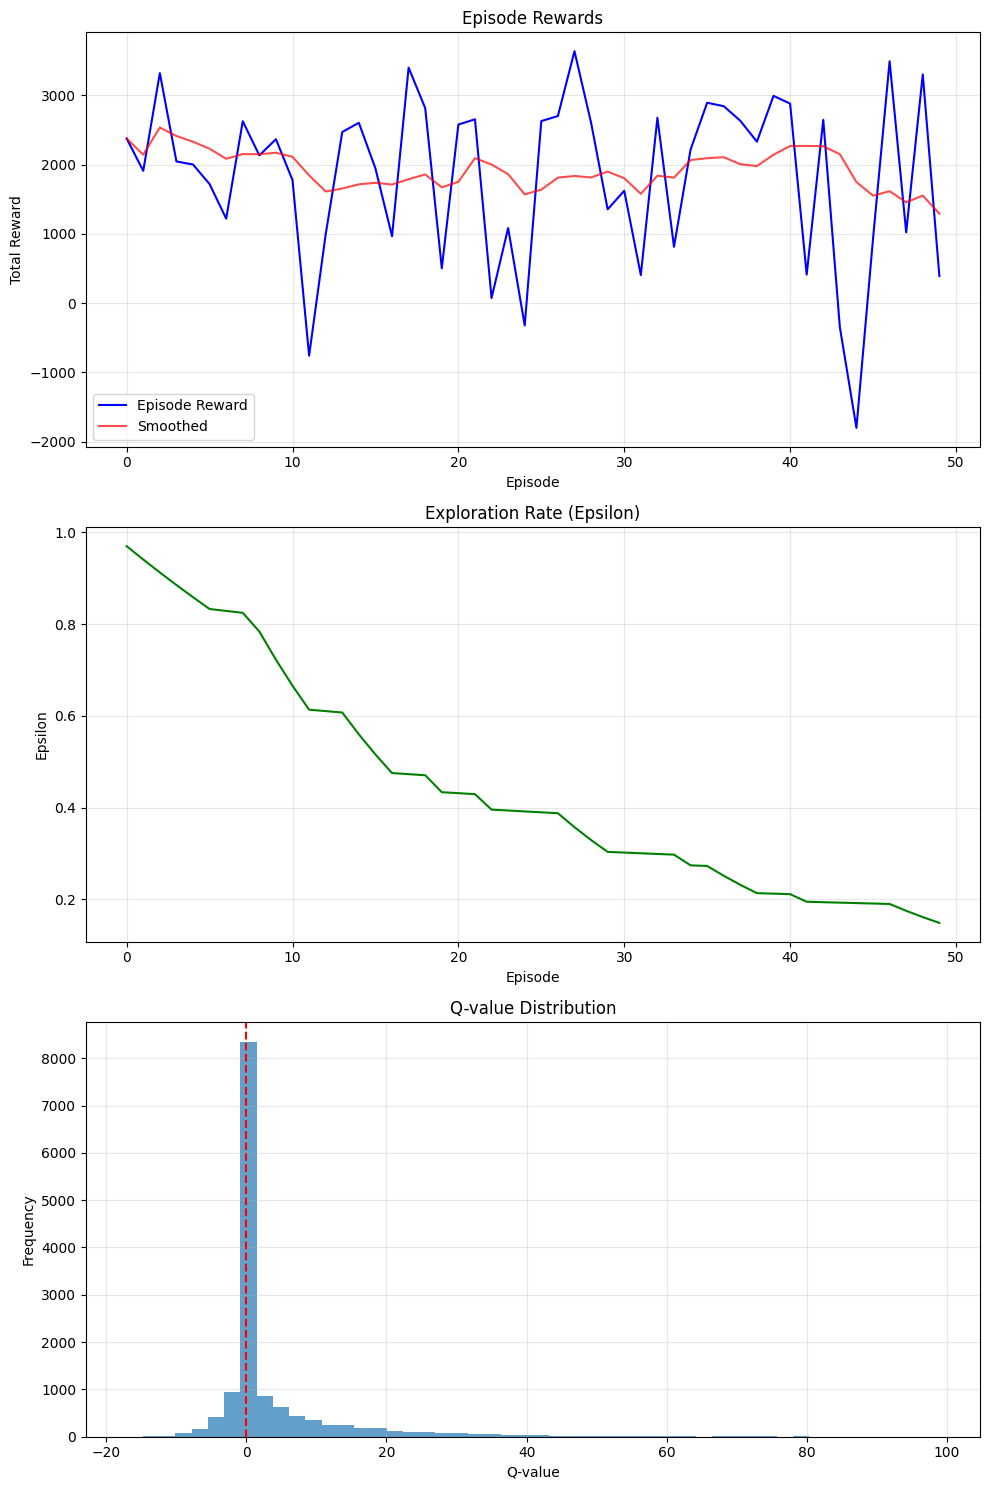


Starting evaluation phase with the best model...

Loading best model from enhanced_cloud_q_best.pkl for evaluation...
Model loaded from enhanced_cloud_q_best.pkl
Evaluating model for 200 steps...
Starting evaluation for 200 steps...
  Step 0/200...
  Step 25/200...
  Step 50/200...
  Step 75/200...
Evaluation complete. Total reward: 2337.61
Starting rule-based evaluation for 200 steps...
  Step 0/200...
  Step 25/200...
  Step 50/200...
  Step 75/200...
Rule-based evaluation complete. Total reward: 1537.24


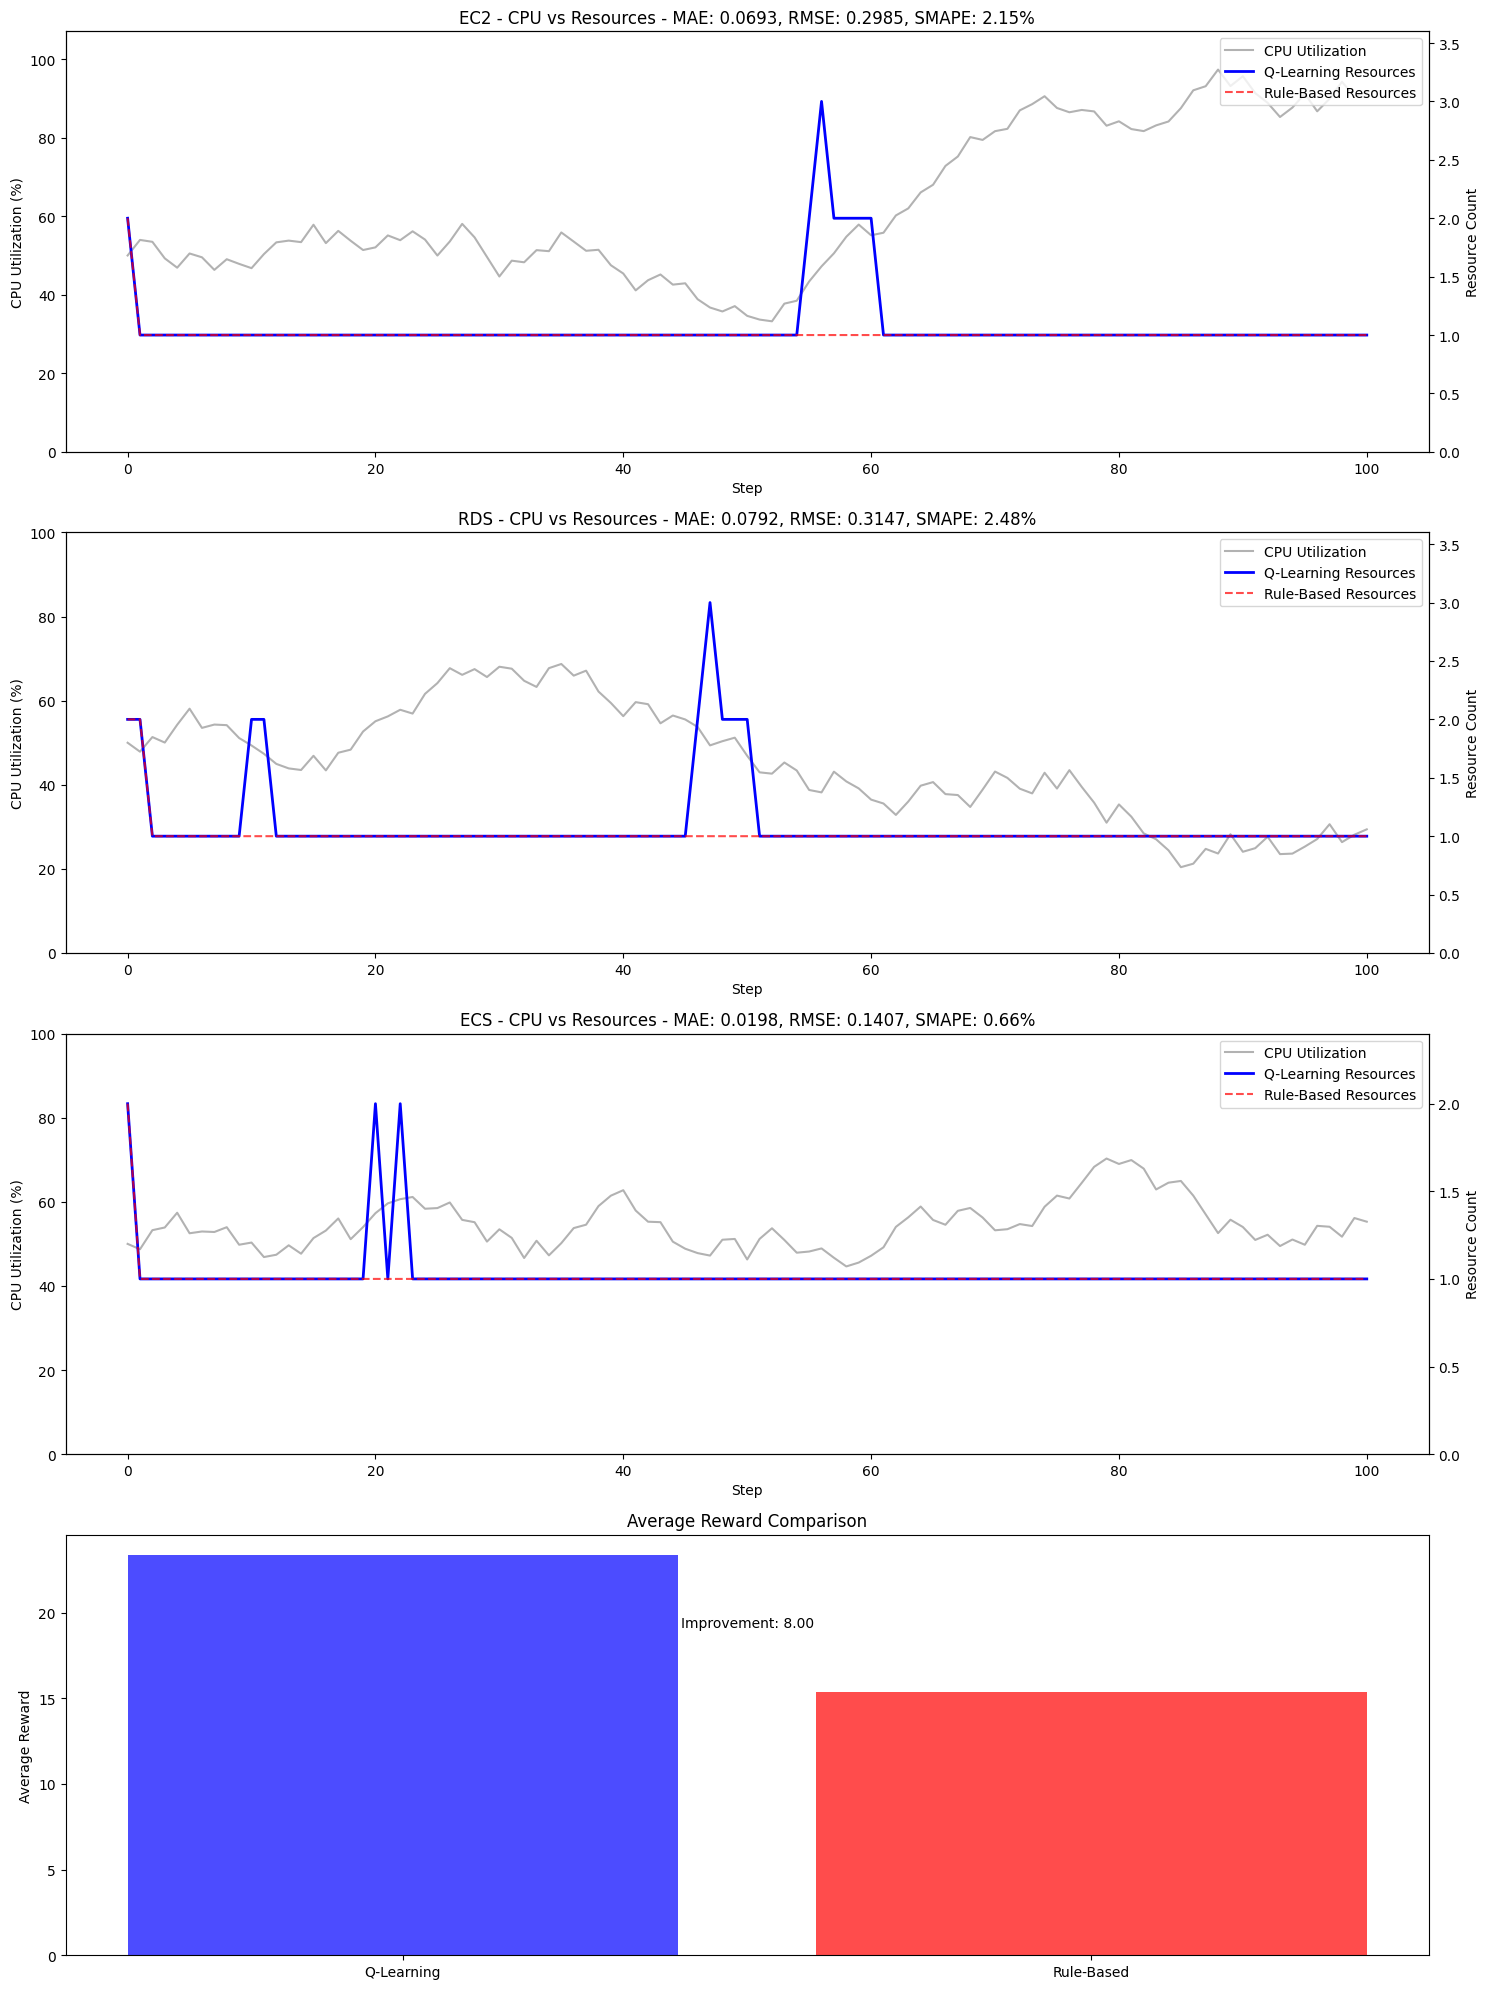


EVALUATION METRICS

EC2 Metrics:
  MAE: 0.0693
  MSE: 0.0891
  RMSE: 0.2985
  SMAPE: 2.15%

RDS Metrics:
  MAE: 0.0792
  MSE: 0.0990
  RMSE: 0.3147
  SMAPE: 2.48%

ECS Metrics:
  MAE: 0.0198
  MSE: 0.0198
  RMSE: 0.1407
  SMAPE: 0.66%

Overall Performance:
  Q-Learning Average Reward: 23.3761
  Rule-Based Average Reward: 15.3724
  Reward Improvement: 8.0038


Final Q-Learning reward: 2337.61
Final Rule-Based reward: 1537.24
Improvement: 800.38

Training and evaluation complete!
Best model was from episode 28 with reward 3639.95


In [ ]:
# Main function to run the entire pipeline
def main():
    """Main function to run the enhanced cloud resource optimization with training and evaluation."""
    # Hardcoded defaults
    episodes = 50   # Number of training episodes
    eval_steps = 200  # Number of evaluation steps
    
    # Load data
    print("\nLoading data...")
    try:
        data = load_data()
    except Exception as e:
        print(f"Error loading data: {e}")
        print("Proceeding with empty data - will use simulated data.")
        data = {}
    
    # Create environment
    print("\nInitializing enhanced environment...")
    env = EnhancedCloudEnvironment(data)
    
    # Training phase
    print("\nInitializing enhanced Q-learning agent for training...")
    agent = EnhancedQAgent(bins_per_dim=BINS_PER_DIM)
    
    print(f"\nTraining enhanced model for {episodes} episodes...")
    trained_agent, best_episode, best_reward = train_enhanced_agent(
        env, agent, num_episodes=episodes, save_path='enhanced_cloud_q.pkl')
    
    # Evaluation phase
    print("\nStarting evaluation phase with the best model...")
    best_model_path = 'enhanced_cloud_q_best.pkl'
    eval_agent = EnhancedQAgent(bins_per_dim=BINS_PER_DIM)
    
    if os.path.exists(best_model_path):
        print(f"\nLoading best model from {best_model_path} for evaluation...")
        if eval_agent.load_model(best_model_path):
            # Evaluate the best model
            metrics, ql_reward, rb_reward = evaluate_model_performance(
                eval_agent, env, num_steps=eval_steps)
            
            # Print metrics
            print_metrics(metrics)
            
            print(f"\nFinal Q-Learning reward: {ql_reward:.2f}")
            print(f"Final Rule-Based reward: {rb_reward:.2f}")
            print(f"Improvement: {ql_reward - rb_reward:.2f}")
        else:
            print(f"Failed to load best model from {best_model_path}. Evaluating final trained model instead...")
            metrics, ql_reward, rb_reward = evaluate_model_performance(
                trained_agent, env, num_steps=eval_steps)
            print_metrics(metrics)
            print(f"\nFinal Q-Learning reward: {ql_reward:.2f}")
            print(f"Final Rule-Based reward: {rb_reward:.2f}")
            print(f"Improvement: {ql_reward - rb_reward:.2f}")
    else:
        print(f"Best model file {best_model_path} not found. Evaluating final trained model instead...")
        metrics, ql_reward, rb_reward = evaluate_model_performance(
            trained_agent, env, num_steps=eval_steps)
        print_metrics(metrics)
        print(f"\nFinal Q-Learning reward: {ql_reward:.2f}")
        print(f"Final Rule-Based reward: {rb_reward:.2f}")
        print(f"Improvement: {ql_reward - rb_reward:.2f}")
    
    print("\nTraining and evaluation complete!")
    print(f"Best model was from episode {best_episode} with reward {best_reward:.2f}")

if __name__ == "__main__":
    try:
        main()
    except Exception as e:
        print(f"Error in main: {e}")
        import traceback
        traceback.print_exc()